# Online Shoppers Purchasing Intention Dataset Analysis

## 1. Dataset Information and Importing Libraries

The dataset used in this analysis is the "Online Shoppers Purchasing Intention Dataset" from the UCI Machine Learning Repository. It was published on 05/04/2018, meeting the requirement of being published after 01/01/2018.

Link to the dataset: https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset

This dataset contains 12,330 sessions (rows) and 18 features, including the target variable 'Revenue'. The dataset is focused on predicting whether a session will result in a purchase or not.

Let's start by importing the necessary libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

## 2. Data Loading and Initial Exploration

Let's load the data and take a look at its structure:

In [2]:
data = pd.read_csv('online_shoppers_intention.csv')
print(data.info())
print("\nFirst few rows of the dataset:")
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

## 3. Data Exploration and Visualization

Now, let's explore the distributions of our features and their relationships:

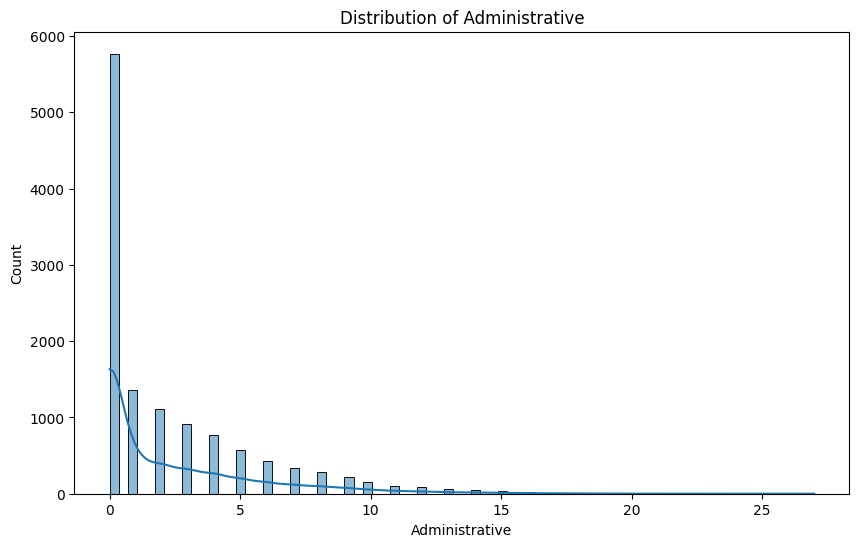

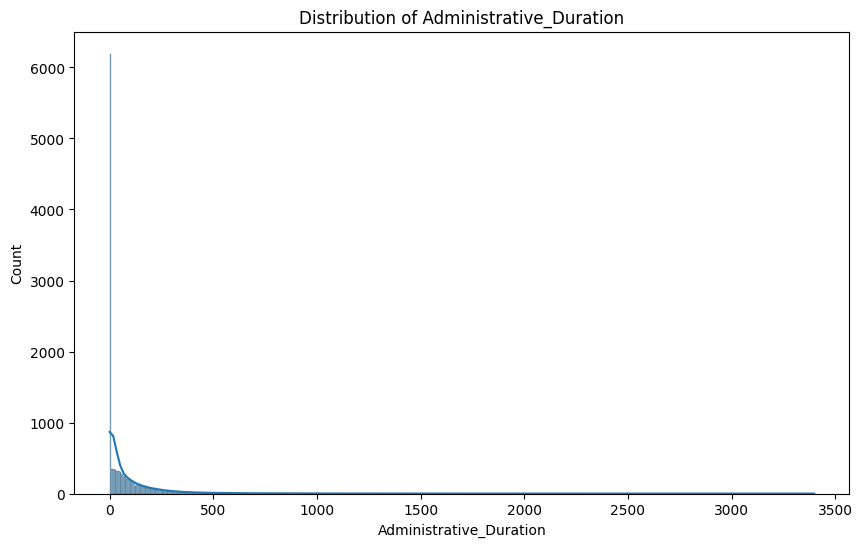

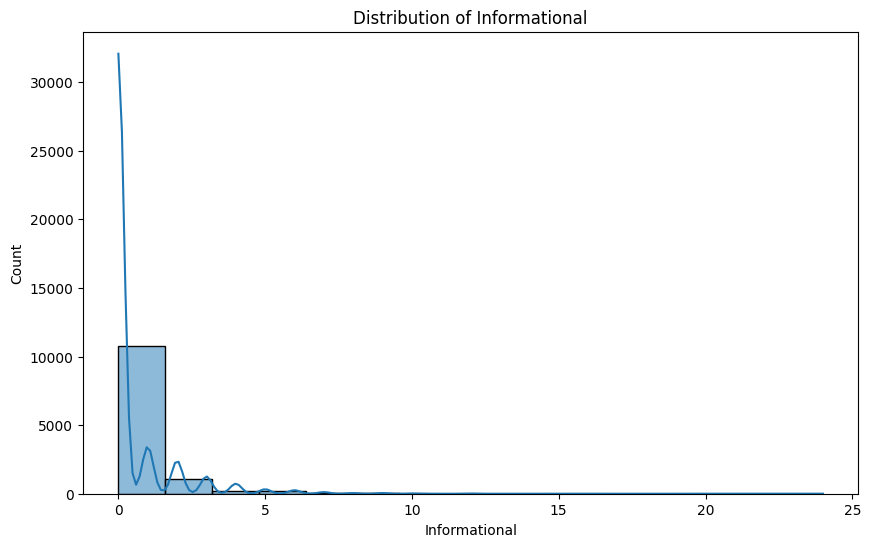

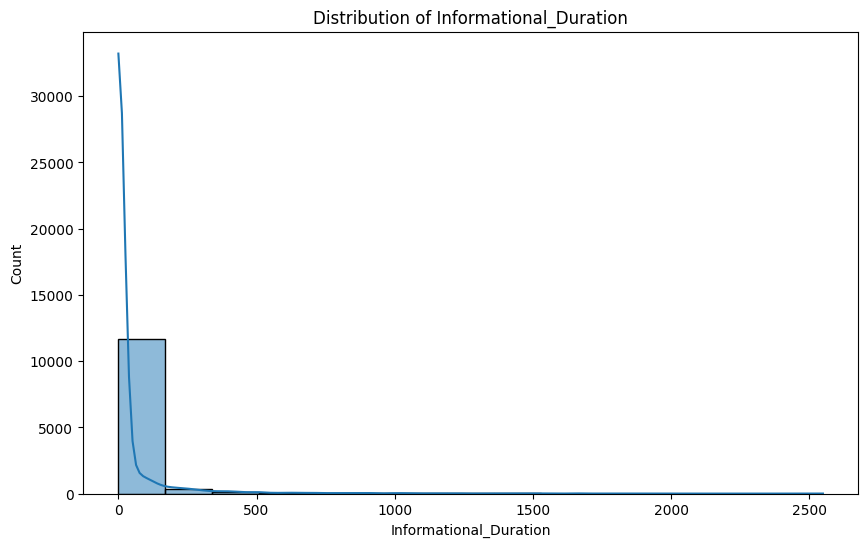

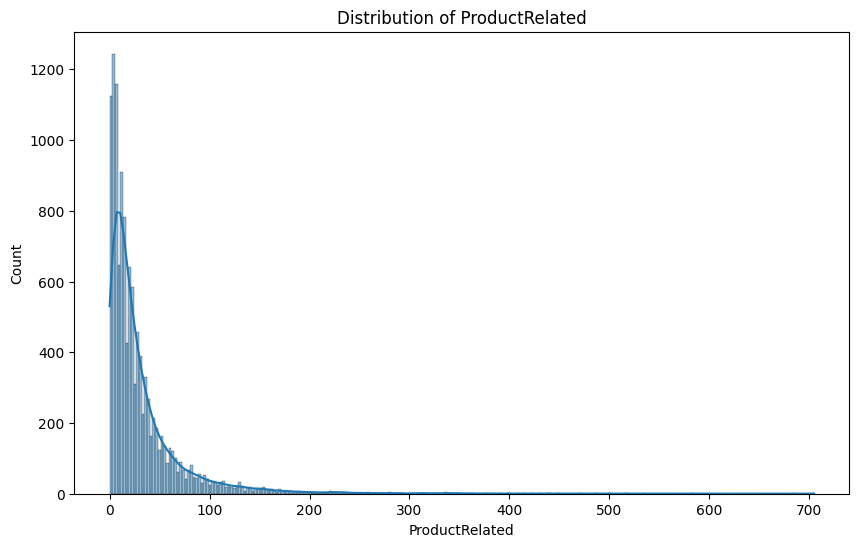

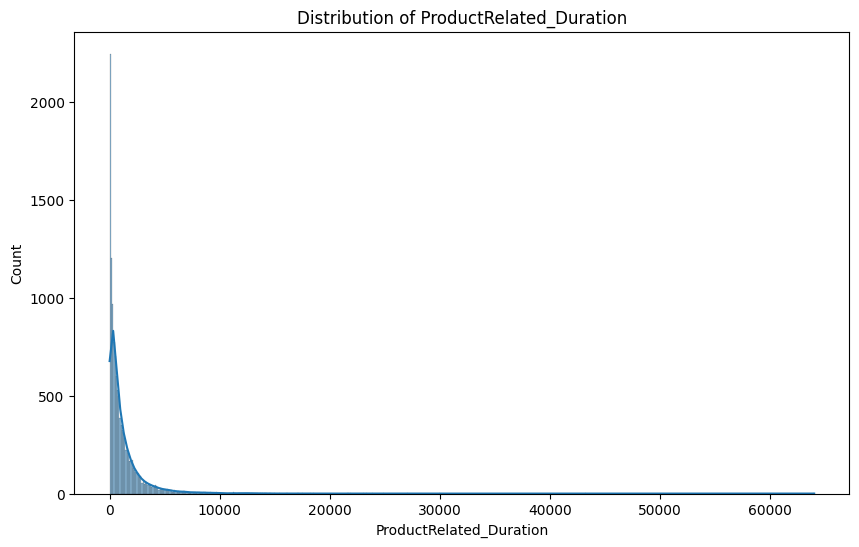

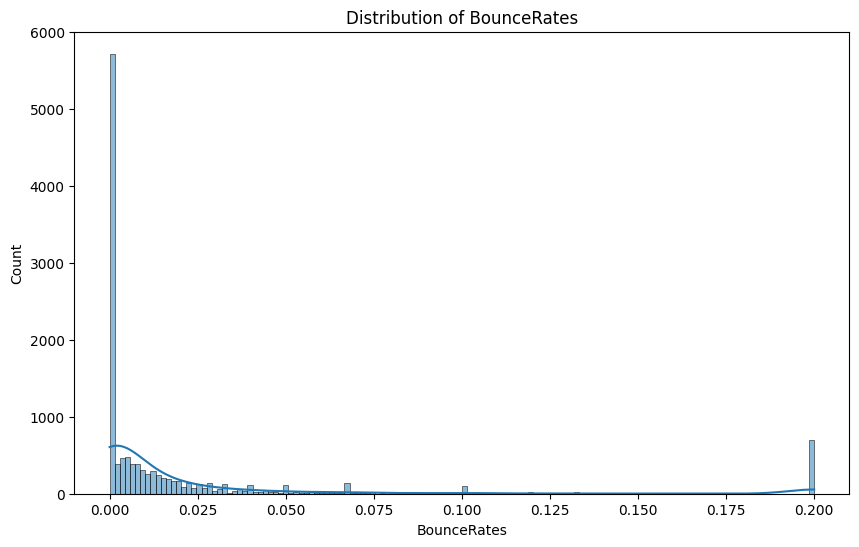

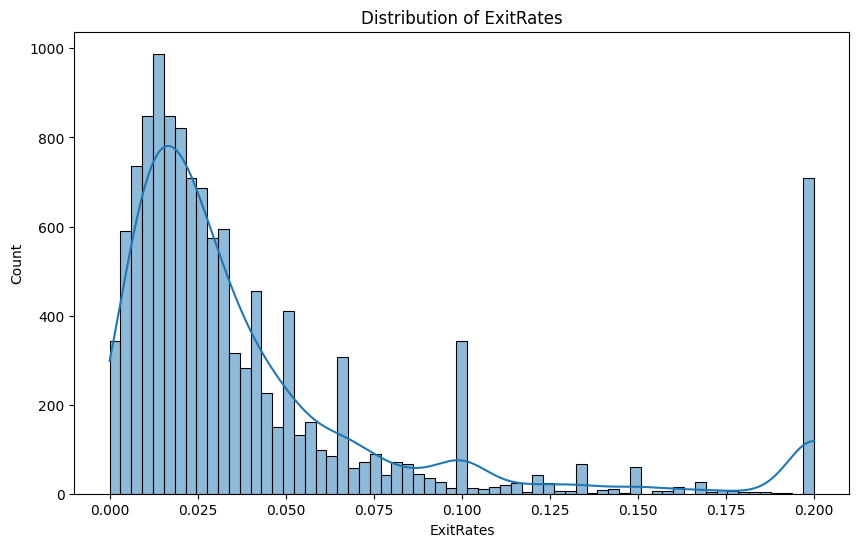

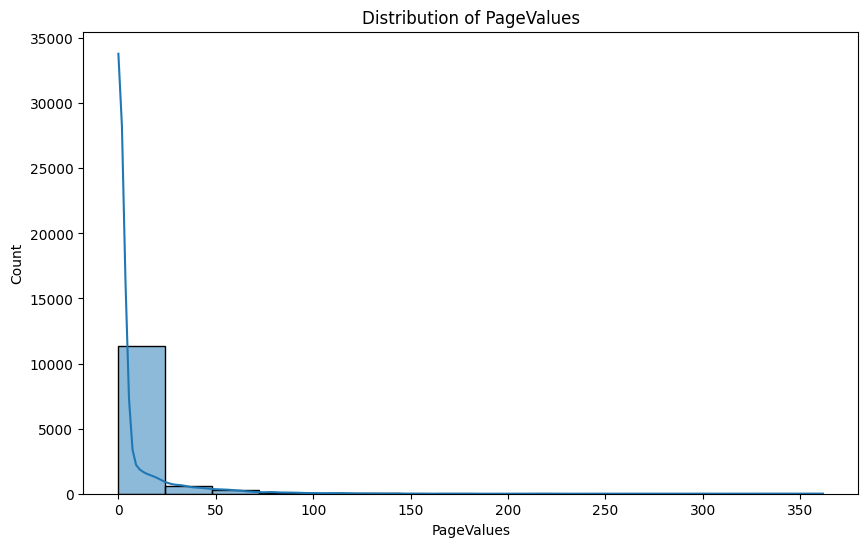

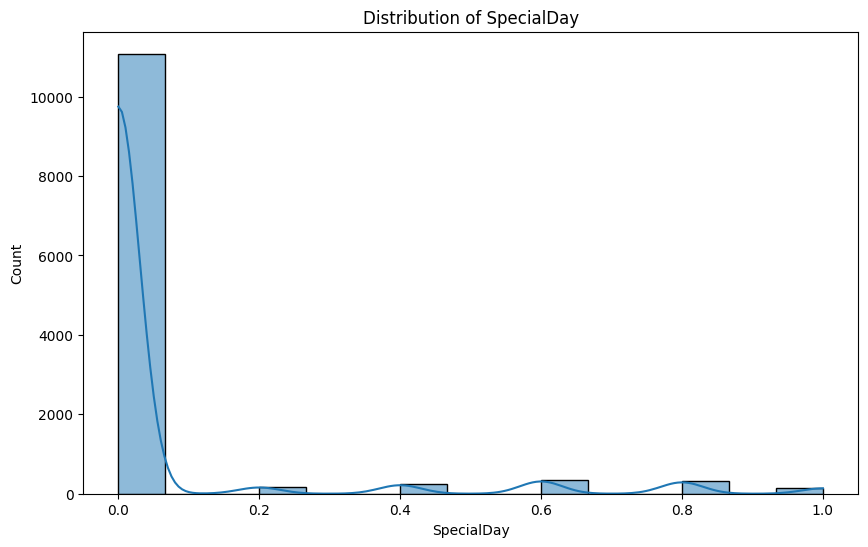

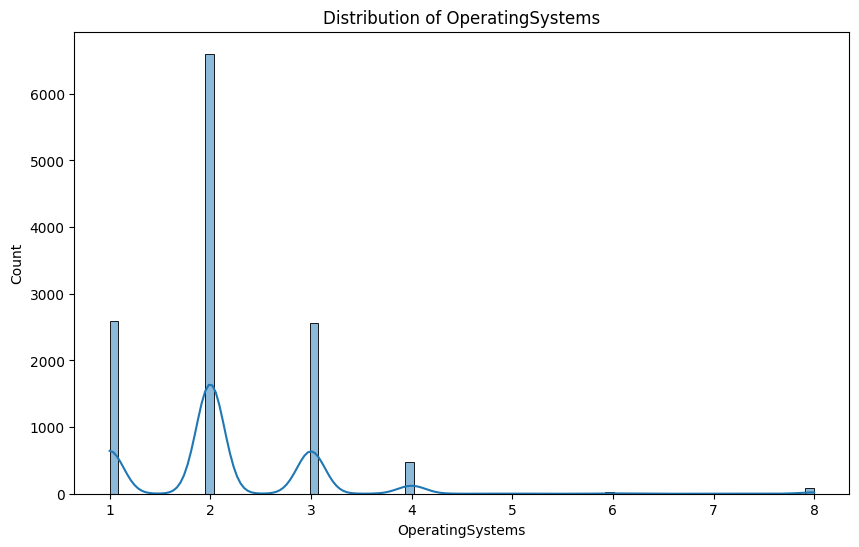

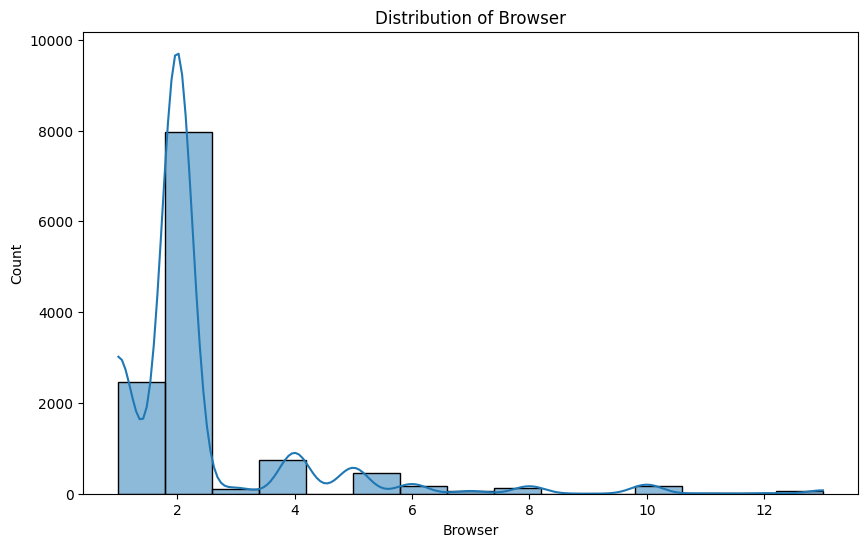

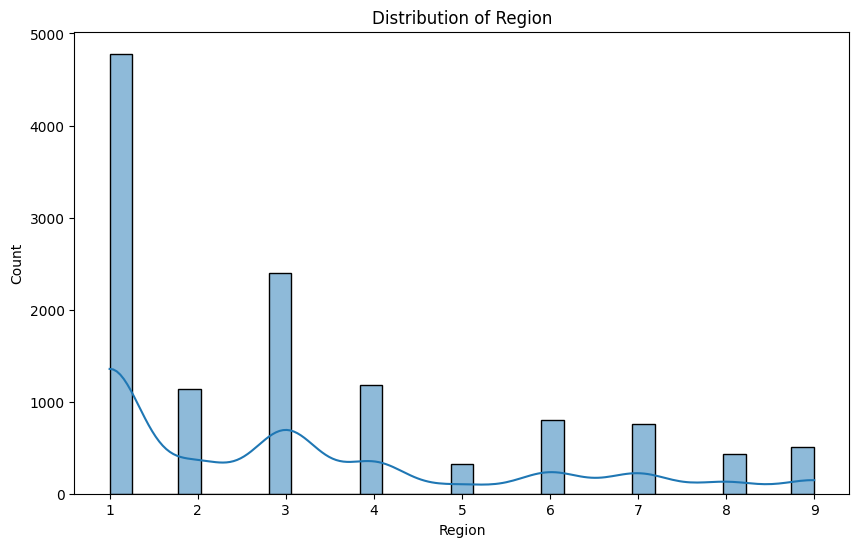

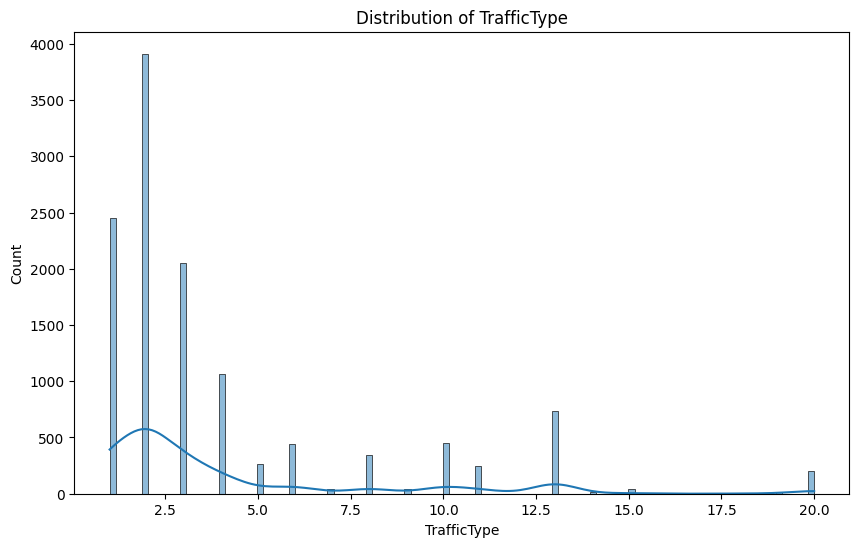

C:\Users\ar356\AppData\Local\Temp\ipykernel_10500\3869983571.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, cmap='coolwarm')


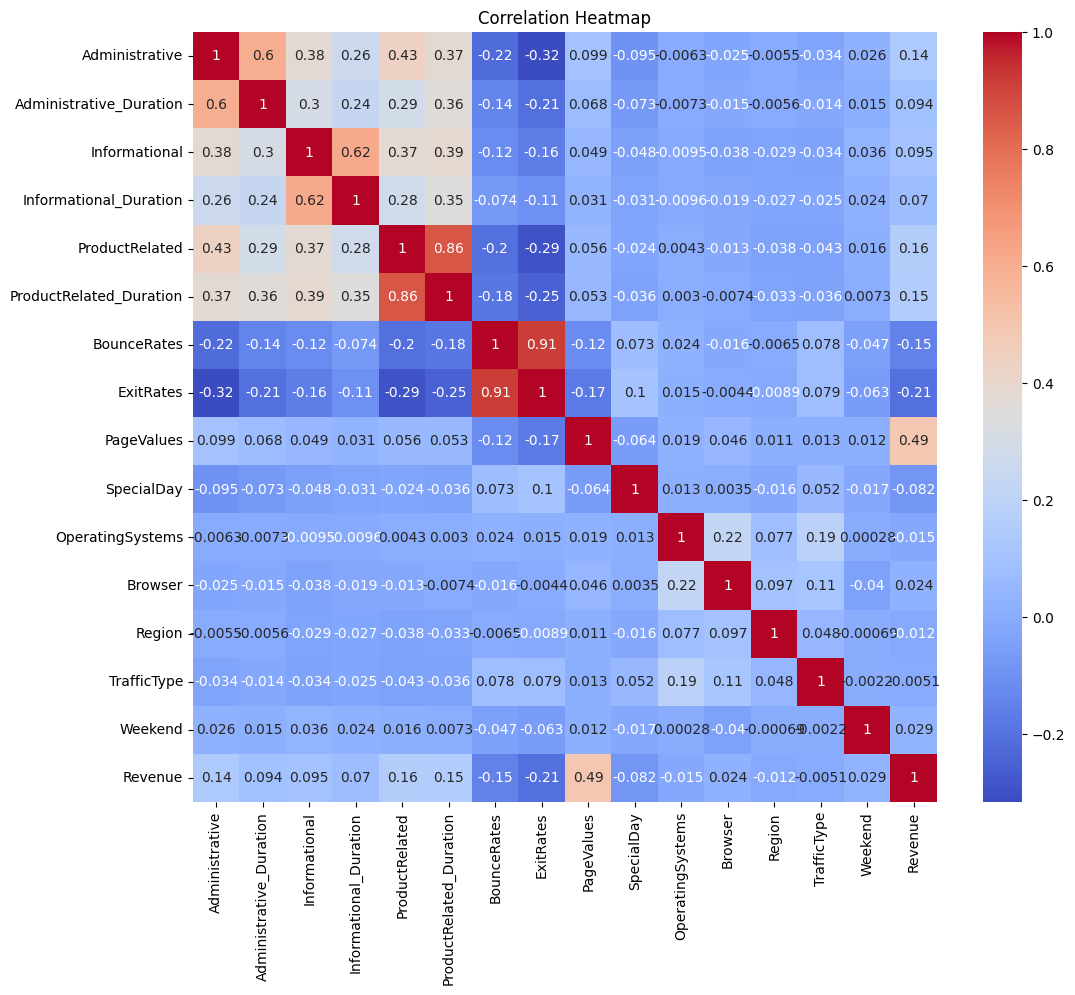

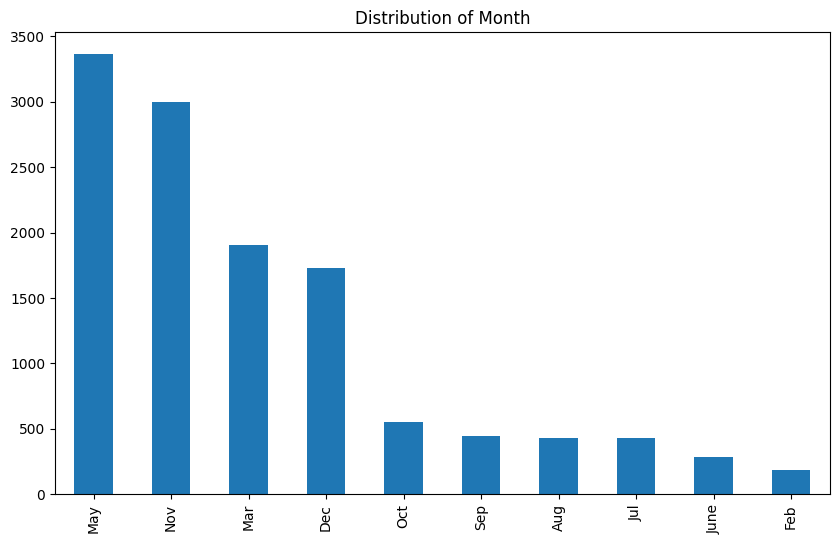

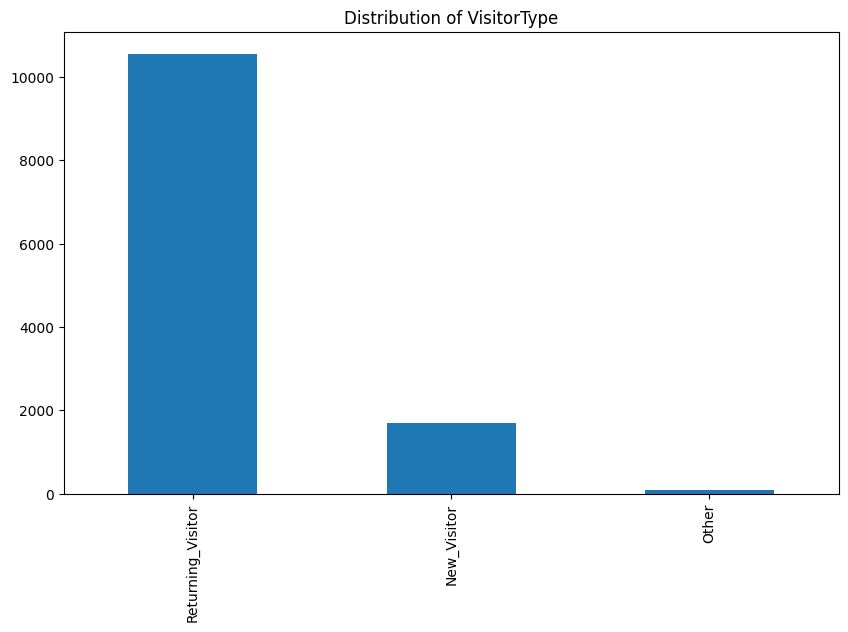

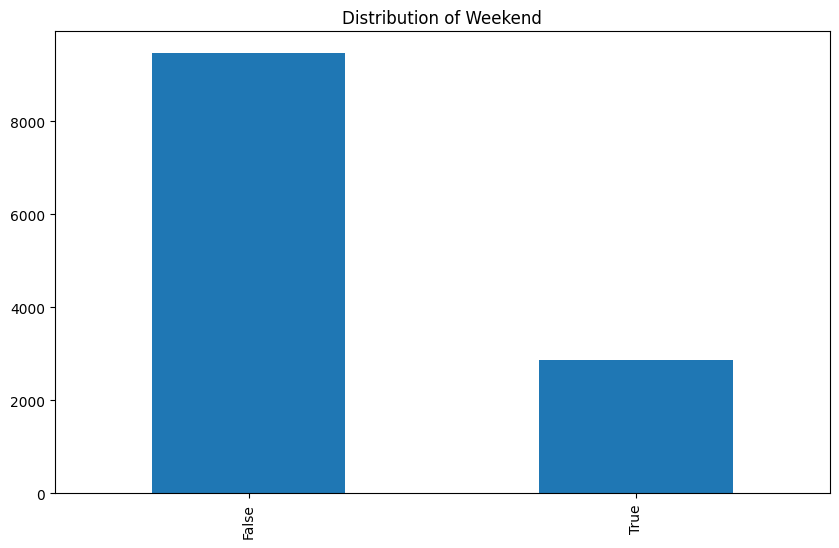

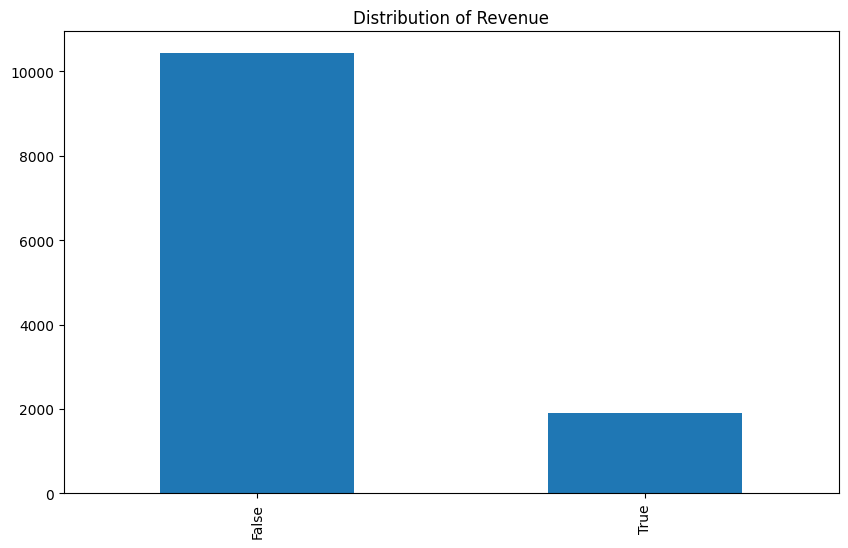

In [3]:
# Function to plot distribution of a feature
def plot_distribution(feature):
    plt.figure(figsize=(10, 6))
    sns.histplot(data[feature], kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Plot distributions for all numerical features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    plot_distribution(feature)

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Categorical features analysis
categorical_features = data.select_dtypes(include=['object', 'bool']).columns
for feature in categorical_features:
    plt.figure(figsize=(10, 6))
    data[feature].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {feature}')
    plt.show()

## 4. Data Preprocessing

Based on our exploratory analysis, we'll perform the following preprocessing steps:

In [4]:
# Drop duplicate entries
data = data.drop_duplicates()
print(f"Number of rows after dropping duplicates: {len(data)}")

# Convert categorical columns to numeric
data['Month'] = data['Month'].astype('category').cat.codes
data['VisitorType'] = data['VisitorType'].astype('category').cat.codes
data['Weekend'] = data['Weekend'].astype(int)
data['Revenue'] = data['Revenue'].astype(int)

# Log transformation for highly skewed features
skewed_features = ['Administrative_Duration', 'Informational_Duration', 'ProductRelated_Duration']
data[skewed_features] = data[skewed_features].apply(lambda x: np.log1p(x))

# Normalization
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

print("\nDataset after preprocessing:")
print(data.head())

Number of rows after dropping duplicates: 12205

Dataset after preprocessing:
   Administrative  Administrative_Duration  Informational  \
0       -0.702302                -0.985196      -0.398824   
1       -0.702302                -0.985196      -0.398824   
2       -0.702302                -0.985196      -0.398824   
3       -0.702302                -0.985196      -0.398824   
4       -0.702302                -0.985196      -0.398824   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                -0.46775       -0.696218                -3.070391   
1                -0.46775       -0.673793                -0.942592   
2                -0.46775       -0.696218                -3.070391   
3                -0.46775       -0.673793                -2.408111   
4                -0.46775       -0.494387                 0.213953   

   BounceRates  ExitRates  PageValues  SpecialDay  Month  OperatingSystems  \
0     3.969402   3.434394   -0.318962    -0.31024      2

Justification for preprocessing steps:
1. Dropping duplicates: Duplicate entries can lead to overfitting and bias in our models.
2. Converting categorical to numeric: Many machine learning algorithms require numeric input.
3. Log transformation: Applied to duration features which showed high positive skewness in our distribution plots.
4. Normalization: Applied to all numerical features to bring them to a common scale, which is important for many machine learning algorithms.

## 5. Modeling

We'll use seven different models, including a self-researched model (SVM), and fine-tune them using GridSearchCV:

In [5]:
# Prepare the data for modeling
X = data.drop('Revenue', axis=1)
y = data['Revenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier(),
    'SVM': SVC(),  # Self-researched model
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Fine-tune models using GridSearchCV
param_grids = {
    'Logistic Regression': {'C': [0.1, 1, 10]},
    'Random Forest': {'n_estimators': [100, 200], 'max_depth': [10, 20]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'LightGBM': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1]},
    'SVM': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear']},
    'KNN': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'Decision Tree': {'max_depth': [5, 10, 20], 'min_samples_split': [2, 5, 10]}
}

best_models = {}
for model_name, model in models.items():
    print(f"Fine-tuning {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters: {grid_search.best_params_}")

# Evaluate models
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    print(f'\n{model_name} Results:')
    print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
    print(f'Classification Report:\n{classification_report(y_test, y_pred)}')

Fine-tuning Logistic Regression...
Best parameters: {'C': 1}
Fine-tuning Random Forest...
Best parameters: {'max_depth': 10, 'n_estimators': 100}
Fine-tuning XGBoost...
Best parameters: {'learning_rate': 0.01, 'n_estimators': 200}
Fine-tuning LightGBM...
[LightGBM] [Info] Number of positive: 1237, number of negative: 6574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000676 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1894
[LightGBM] [Info] Number of data points in the train set: 7811, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.158366 -> initscore=-1.670433
[LightGBM] [Info] Start training from score -1.670433
[LightGBM] [Info] Number of positive: 1237, number of negative: 6574
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `forc

## 6. Model Comparison and Conclusion

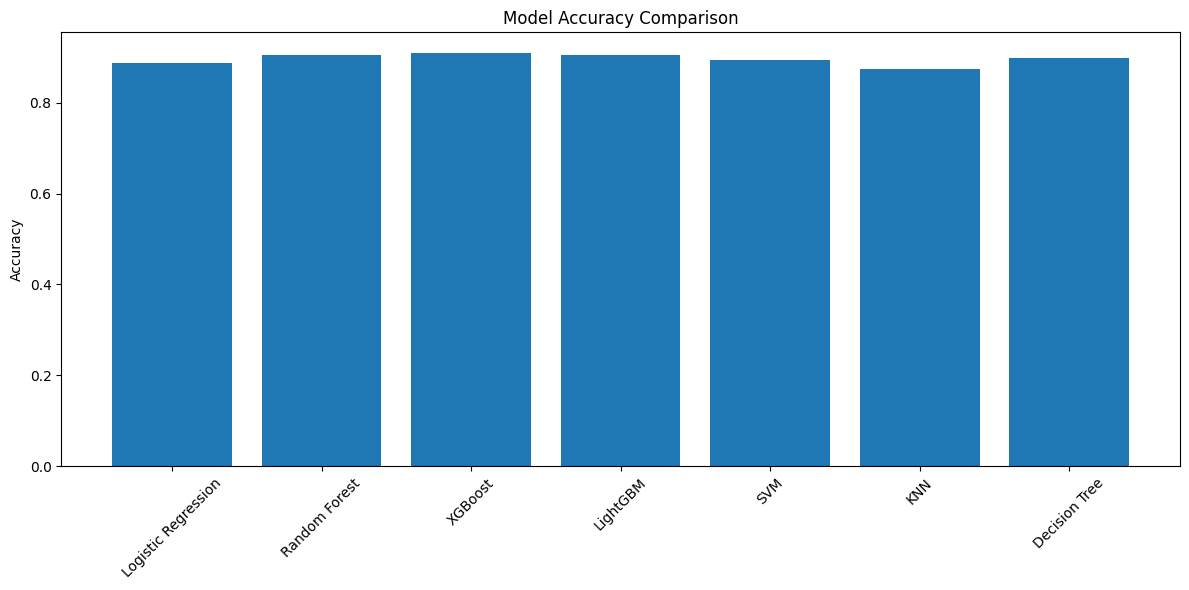


Conclusion:
Based on our analysis, the best performing model for predicting online shopper purchasing intention is: XGBoost

This model achieved an accuracy of: 0.9091

However, all models performed relatively well. Here's a ranking of the models based on accuracy:
1. XGBoost: 0.9091
2. Random Forest: 0.9050
3. LightGBM: 0.9037
4. Decision Tree: 0.8980
5. SVM: 0.8943
6. Logistic Regression: 0.8865
7. KNN: 0.8742

The choice of model in a real-world scenario might depend on factors such as interpretability, computational resources, and specific business requirements.

For instance:
- Logistic Regression and Decision Trees offer high interpretability.
- Random Forest, XGBoost, and LightGBM often provide high accuracy but may be more computationally intensive.
- KNN and SVM can be effective but may not scale well to very large datasets.

Further steps could include:
1. Feature importance analysis to understand which factors most influence purchasing behavior.
2. Hyperparameter tuning wit

In [6]:
# Comparing model performances
model_accuracies = {name: accuracy_score(y_test, model.predict(X_test)) for name, model in best_models.items()}

plt.figure(figsize=(12, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\nConclusion:")
best_model = max(model_accuracies, key=model_accuracies.get)
print(f"Based on our analysis, the best performing model for predicting online shopper purchasing intention is: {best_model}")
print(f"\nThis model achieved an accuracy of: {model_accuracies[best_model]:.4f}")
print("\nHowever, all models performed relatively well. Here's a ranking of the models based on accuracy:")

for i, (model, accuracy) in enumerate(sorted(model_accuracies.items(), key=lambda x: x[1], reverse=True), 1):
    print(f"{i}. {model}: {accuracy:.4f}")

print("\nThe choice of model in a real-world scenario might depend on factors such as interpretability, computational resources, and specific business requirements.")
print("\nFor instance:")
print("- Logistic Regression and Decision Trees offer high interpretability.")
print("- Random Forest, XGBoost, and LightGBM often provide high accuracy but may be more computationally intensive.")
print("- KNN and SVM can be effective but may not scale well to very large datasets.")
print("\nFurther steps could include:")
print("1. Feature importance analysis to understand which factors most influence purchasing behavior.")
print("2. Hyperparameter tuning with a wider range of parameters for the top-performing models.")
print("3. Ensemble methods combining multiple models to potentially improve performance.")
print("4. Addressing any class imbalance issues if present in the target variable.")